# ロジスティック回帰 

## ロジスティック回帰（2値分類）
--- 
美味しいワイン(1), 美味しくないワイン(0)として、2つのクラスに分類するモデルを構築する

## 環境構築

In [26]:
# 分析に必要なライブラリをインポート
import pandas as pd
import numpy as np
# 可視化ライブラリのインポート
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## データセット準備
### 読み込み

In [6]:
# データセットを読み込む
df = pd.read_csv("../dataset/winequality-red.csv", sep=";")

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 美味しいワイン(1)と美味しくないワイン(0)とする関数を定義する

In [30]:
def delicious(x):
    # もしqualityが7以上であれば美味しい(1)
    if x >= 7:
        return 1
    # 7以上でなければ、美味しくない(0)
    else:
        return 0

"""
applyを使って、美味しいか、そうでないかの2値分類結果を
列名「delicious_score」としてDataFrameに新たに追加する
"""
df['delicious_score'] = df['quality'].apply(delicious)

# 正しくDataFrameに列が追加されたのか確認
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,delicious_score
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


- これでデータセットの準備ができた
- ここまでの作業は*中間テーブル作成*の作業にあたる

### 各列の平均値を比較する
美味しいワイン(1)と美味しくないワイン(0)における説明変数の平均値の違いを比較してみる

In [32]:
df.groupby("delicious_score").mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
delicious_score,,,,,,,,,,,,
0,8.236831,0.547022,0.254407,2.512120,0.089281,16.172214,48.285818,0.996859,3.314616,0.644754,10.251037,5.408828
1,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,34.889401,0.996030,3.288802,0.743456,11.518049,7.082949


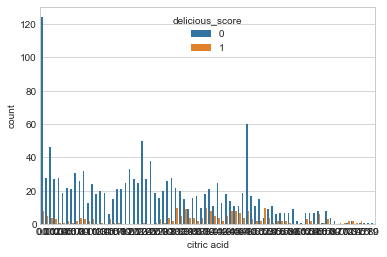

In [34]:
sns.countplot('citric acid',data=df.sort_values('citric acid'),hue='delicious_score')

### 特徴量と特徴量の相関性


([<matplotlib.axis.YTick at 0x1a2bf8e2b0>,
 <a list of 13 Text yticklabel objects>)

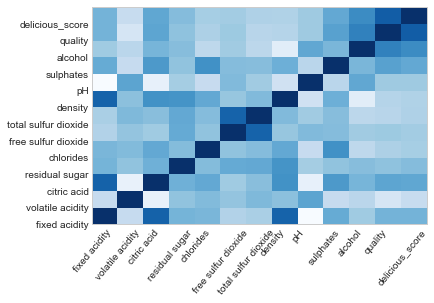

In [53]:
plt.pcolor(df.corr(), cmap="Blues")
plt.xticks(range(0, len(df.columns)), df.columns, rotation=50)
plt.yticks(range(0, len(df.columns)), df.columns, rotation=0)

### 目的変数(Y)と説明変数(X)にそれぞれデータを格納する

In [11]:
# 目的変数
Y = df["delicious_score"]
# 説明変数
X = df.drop(["quality", "delicious_score"], axis=1)

### 学習データ(train)と検証データ(test)に分割する
交差検証(Cross Validation)を行います

#### Cross Validation（交差検証）とは  
統計学において標本データを分割し、その一部をまず解析して、残る部分でその解析のテストを行い、解析自身の妥当性の検証・確認に当てる手法を指す。（Wikipediaより引用）

In [57]:
# 交差検証
from sklearn.cross_validation import train_test_split

# データ分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4,random_state=3)

#### 学習データ量

In [58]:
print [d.shape for d in [X_train, X_test, Y_train, Y_test]]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print([d.shape for d in [X_train, X_test, Y_train, Y_test]])? (<ipython-input-58-a532d5b1e09c>, line 1)

### シグモイド関数
グラフで見るとわかるようにシグモイド関数σ(x)σ(x)は値を(0, 1)の範囲で取るため、この値を確率として解釈して使うことができる

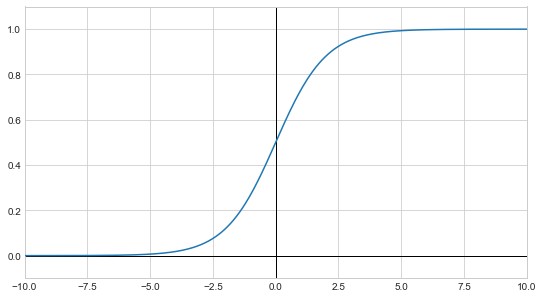

In [54]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

x_range = np.linspace(-10, 10, 501)

plt.figure(figsize=(9,5))
plt.ylim(-0.1, 1.1)
plt.xlim(-10, 10)

plt.plot([-10,10],[0,0], "k", lw=1)
plt.plot([0,0],[-1,1.5], "k", lw=1)
plt.plot(x_range, sigmoid(x_range), zorder=100)

## 機械学習

In [60]:
import pystan
from pystan import StanModel

ModuleNotFoundError: No module named 'pystan'

In [27]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
# 性能の評価用
from sklearn import metrics

# インスタンス生成
log_model = LogisticRegression()

# 学習データを使って機械学習 = モデル作成
log_model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 学習したモデルの予測精度
#### 予測精度の算出方法
学習したモデルを使って予測(predict_Y)と実際の値（Y）を比較することによって算出できる

In [15]:
log_model.score(X_train, Y_train)

0.8821689259645464

およそ88%の予測精度が実現できました。

In [37]:
Y.mean()

0.1357098186366479

実際のYの平均値は0.13です。
ロジスティック回帰による予測モデルは、常に「美味しくない(0)」と出力すると、
全体1-0.13=0.87となり、87%の予測精度が得られます。

この値より、88.2%は若干高いことがわかります。

### 学習したモデルの係数(coefficient)を表示する
どのような変数が予測に影響を与えている（寄与度）のか調べてみましょう

In [39]:
from pandas import DataFrame

# 変数名とその変数を格納するDataFrameを作成
coeff_df = DataFrame([X.columns, log_model.coef_[0]]).T
coeff_df

,0,1
0,fixed acidity,-0.0873674
1,volatile acidity,-2.17903
2,citric acid,0.497435
3,residual sugar,0.0800882
4,chlorides,-0.975882
5,free sulfur dioxide,0.0287969
6,total sulfur dioxide,-0.0307509
7,density,-1.18241
8,pH,-2.41394
9,sulphates,2.20785


#### オッズ比について後で調べる

# 検証

In [40]:
# 検証データで予測
class_predict = log_model.predict(X_test)

# 予測精度確認用
from sklearn import metrics 

# 精度確認
metrics.accuracy_score(Y_test, class_predict) 

0.8703125

### モデル構築のステップ
1. 標準化
2. テストデータと訓練データに分割
3. 外れ値の除去

### モデル概要
---
- 今回は教師あり学習
- 

In [5]:
# 多重共線性があるか分析


In [6]:
#statsmodelsのvifをインポート
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ↑この続きはあとでやる

最適な重回帰モデルをステップワイズ法でモデル選択（AICで評価）

# ロジスティック回帰モデル

In [7]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

In [8]:
# 機械学習用です。
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# もう一つ、性能の評価用に
from sklearn import metrics

/Users/h_fukano/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# 教師データの作成
y = df["quality"]
x = df.drop("quality", axis=1)

In [11]:
# データ分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [15]:
# 機械学習
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# 評価用ライブラリ
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# 評価
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("正解率　= ", accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00        10
          5       0.64      0.78      0.70       122
          6       0.56      0.67      0.61       135
          7       0.44      0.08      0.14        49
          8       0.00      0.00      0.00         2

avg / total       0.55      0.59      0.55       320

正解率　=  0.59375


/Users/h_fukano/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1]:
# pickleのインポート
import pickle

In [2]:
#pickleでモデルを保存する
# モデルを保存する
filename = 'nullsuckAi_model.sav'
pickle.dump(model, open(filename, 'wb'))



NameError: name 'model' is not defined

NameError: name 'X_test' is not defined